In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as mpatches
import pandas as pd

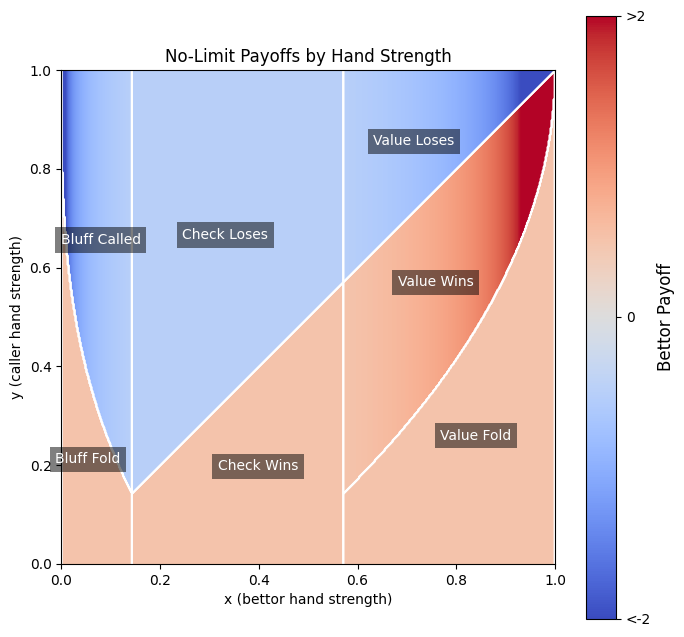

In [24]:
# No limit continuous poker values

# ---- Parameters ----
grid_size = 501  # must match your Mathematica export
xs = np.linspace(0, 1, grid_size)
ys = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(xs, ys, indexing='ij')
color_cap = 2  # max abs value for color clipping

# ---- Load payoff data from Mathematica ----
payoff_data = pd.read_csv("payoff_values.csv", header=None).astype(float).values
payoff_clipped = np.clip(payoff_data, -color_cap, color_cap)

# ---- Thresholds and inverse functions ----
bluff_threshold = 1 / 7
value_threshold = 4 / 7

def safe_bluff_s(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        s = np.where((x > 0) & (x < bluff_threshold), (1 / (7 * x)**(1/3)) - 1, np.nan)
    return s

def safe_value_s(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        s = np.where((x > value_threshold) & (x < 1), np.sqrt(3 / (7 * (1 - x))) - 1, np.nan)
    return s

def call_threshold_y(s):
    return 1 - 6 / (7 * (1 + s))

# ---- Classify outcomes with error handling ----
def classify_outcome(x, y):
    if x < bluff_threshold:
        s = safe_bluff_s(x)
        if np.isnan(s): return "Undefined"
        return "Bluff_Called" if y > call_threshold_y(s) else "Bluff_Fold"
    elif x > value_threshold:
        s = safe_value_s(x)
        if np.isnan(s): return "Undefined"
        if y > call_threshold_y(s):
            return "Value_Wins" if y < x else "Value_Loses"
        else:
            return "Value_Fold"
    else:
        return "Check_Wins" if x > y else "Check_Loses"

# ---- Vectorize classification over grid ----
outcome_type = np.empty((grid_size, grid_size), dtype=object)
for i in range(grid_size):
    for j in range(grid_size):
        outcome_type[i, j] = classify_outcome(xs[i], ys[j])

# ---- Convert outcome types to indices ----
region_labels = [
    "Bluff_Called", "Bluff_Fold",
    "Value_Wins", "Value_Loses", "Value_Fold",
    "Check_Wins", "Check_Loses"
]

regions = [
    "Bluff_Called",
    "Bluff_Fold",
    "Value_Wins",
    "Value_Loses",
    "Value_Fold",
    "Check_Wins",
    "Check_Loses"
]

label_to_index = {label: i for i, label in enumerate(region_labels)}
region_indices = np.vectorize(lambda l: label_to_index.get(l, -1))(outcome_type)

# ---- Plot heatmap with region contours and labels ----
fig, ax = plt.subplots(figsize=(7, 7))

# Heatmap
c = ax.imshow(
    payoff_clipped.T,
    extent=[0, 1, 0, 1],
    origin='lower',
    cmap='coolwarm',
    norm=TwoSlopeNorm(vmin=-color_cap, vcenter=0, vmax=color_cap)
)
cbar = fig.colorbar(c, ax=ax, shrink=0.9)
cbar.set_label("Bettor Payoff", fontsize=12)
cbar.set_ticks([-color_cap, 0, color_cap])
cbar.set_ticklabels([f"<-{color_cap}", "0", f">{color_cap}"])

# Region boundaries as contours
for label in regions:
    mask = outcome_type == label
    # Draw contour only if region exists
    if np.any(mask):
        ax.contour(
            X, Y, mask.astype(float),
            levels=[0.5],
            colors='white',
            linewidths=1.5
        )
        # Add a text label in the center of the region
        region_center = np.argwhere(mask)
        if len(region_center) > 0:
            center_x, center_y = region_center.mean(axis=0)
            ax.text(
                xs[int(center_x)], ys[int(center_y)],
                label.replace("_", " "),  # Replace underscores with spaces for readability
                color="white",
                fontsize=10,
                ha="center",
                va="center",
                bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
            )

# Remove the legend
ax.set_xlabel("x (bettor hand strength)")
ax.set_ylabel("y (caller hand strength)")
ax.set_title("No-Limit Payoffs by Hand Strength")
plt.tight_layout()
plt.savefig("payoff_heatmap_with_regions_labeled.png", dpi=300)
plt.show()


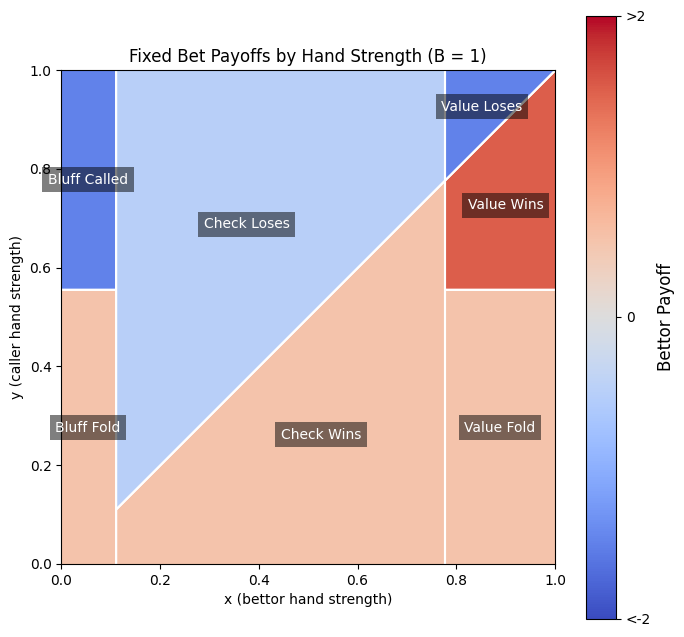

In [26]:
# continuous poker

# ---- Parameters ----
grid_size = 501  # must match export resolution from Mathematica
xs = np.linspace(0, 1, grid_size)
ys = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(xs, ys, indexing='ij')
color_cap = 2
s = 1  # fixed bet size (should match the s used in Mathematica)

# ---- Load payoff data ----
payoff_data = (
    pd.read_csv("payoff_values_s_1.csv", header=None)
    .replace("NaN", np.nan)
    .astype(float)
    .values
)
payoff_clipped = np.clip(np.nan_to_num(payoff_data, nan=0), -color_cap, color_cap)

# ---- Fixed threshold functions ----
def bluff_threshold(s):
    return 2 * s / ((1 + 2 * s) * (4 + 2 * s))

def value_threshold(s):
    return (2 + 8 * s + 4 * s**2) / ((1 + 2 * s) * (4 + 2 * s))

def call_threshold(s):
    return (2 * s * (3 + 2 * s)) / ((1 + 2 * s) * (4 + 2 * s))

# ---- Classify outcomes (matches Mathematica logic) ----
def classify_outcome_fixed(x, y, s):
    bth = bluff_threshold(s)
    vth = value_threshold(s)
    cth = call_threshold(s)

    if x < bth:
        return "Bluff_Called" if y > cth else "Bluff_Fold"
    elif x > vth:
        if y > cth:
            return "Value_Wins" if y < x else "Value_Loses"
        else:
            return "Value_Fold"
    else:
        return "Check_Wins" if x > y else "Check_Loses"

# ---- Vectorize outcome classification ----
outcome_type = np.empty((grid_size, grid_size), dtype=object)
for i in range(grid_size):
    for j in range(grid_size):
        outcome_type[i, j] = classify_outcome_fixed(xs[i], ys[j], s)

# ---- Color mapping ----
region_labels = [
    "Bluff_Called", "Bluff_Fold",
    "Value_Wins", "Value_Loses", "Value_Fold",
    "Check_Wins", "Check_Loses"
]

regions = [
    "Bluff_Called",
    "Bluff_Fold",
    "Value_Wins",
    "Value_Loses",
    "Value_Fold",
    "Check_Wins",
    "Check_Loses"
]

label_to_index = {label: i for i, label in enumerate(region_labels)}
region_indices = np.vectorize(lambda l: label_to_index.get(l, -1))(outcome_type)

# ---- Plot heatmap + outcome region boundaries ----
fig, ax = plt.subplots(figsize=(7, 7))

# Heatmap
c = ax.imshow(
    payoff_clipped.T,
    extent=[0, 1, 0, 1],
    origin='lower',
    cmap='coolwarm',
    norm=TwoSlopeNorm(vmin=-color_cap, vcenter=0, vmax=color_cap)
)
cbar = fig.colorbar(c, ax=ax, shrink=0.9)
cbar.set_label("Bettor Payoff", fontsize=12)
cbar.set_ticks([-color_cap, 0, color_cap])
cbar.set_ticklabels([f"<-{color_cap}", "0", f">{color_cap}"])

# Region boundaries as contours
for label in regions:
    mask = outcome_type == label
    # Draw contour only if region exists
    if np.any(mask):
        ax.contour(
            X, Y, mask.astype(float),
            levels=[0.5],
            colors='white',
            linewidths=1.5
        )
        # Add a text label in the center of the region
        region_center = np.argwhere(mask)
        if len(region_center) > 0:
            center_x, center_y = region_center.mean(axis=0)
            ax.text(
                xs[int(center_x)], ys[int(center_y)],
                label.replace("_", " "),  # Replace underscores with spaces for readability
                color="white",
                fontsize=10,
                ha="center",
                va="center",
                bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
            )
ax.set_xlabel("x (bettor hand strength)")
ax.set_ylabel("y (caller hand strength)")
ax.set_title(f"Fixed Bet Payoffs by Hand Strength (B = {s})")
plt.tight_layout()
plt.savefig("payoff_fixed_bet_heatmap.png", dpi=300)
plt.show()
